# Реализация Word2Vec

По центральному слову будем предсказывать контекстное.

In [1]:


text = '''
Кошки и собаки – это домашние животные, которые имеют много общего, но при этом существенно отличаются друг от друга.
Кошки обычно ведут ночной образ жизни, они независимы, осторожны и любят уединение. Кошачьи любят лазать по деревьям, точить когти и охотиться на мелкую добычу, такую как мыши или птицы. В поведении кошек заметна грация, ловкость и скрытность. Мяукание, мурлыканье и шипение – типичные звуки, издаваемые кошками.
Собаки, напротив, активны днём, отличаются преданностью, игривостью и стремлением к общению с человеком. Они обожают прогулки, игры с палкой или мячом и легко поддаются дрессировке. В поведении собак преобладает открытость, дружелюбие и послушание. Собаки умеют лаять, рычать и выть, выражая таким образом свои эмоции.
С точки зрения ухода, кошки более самостоятельны: они сами ухаживают за своей шерстью и редко нуждаются в купании. Собаки же требуют регулярного ухода, расчесывания, прогулок и большего внимания со стороны человека.
Питание собак и кошек также отличается. Собаки всеядны, но им необходимо получать достаточное количество мяса, круп и овощей. Кошки являются преимущественно хищниками и нуждаются в мясе как основном источнике пищи.
Таким образом, кошки и собаки – близкие, но при этом разные животные, каждое со своими уникальными особенностями поведения, ухода и питания.
'''


In [2]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pakorolev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
word_tokenizer = RegexpTokenizer(r'\w+')

In [4]:
tokens = word_tokenizer.tokenize(text)
tokens = [token for token in tokens if token not in stopwords.words('russian')]
print(tokens[:10])
len(tokens)

['Кошки', 'собаки', 'это', 'домашние', 'животные', 'которые', 'имеют', 'общего', 'существенно', 'отличаются']


144

In [5]:
def mapping(tokens):
    """вспомогательная функция для создания словарей word_to_id, id_to_word"""
    word_to_id = {}
    id_to_word = {}
    for i, token in enumerate(set(tokens)):# проходимся только по уникальным словам
        word_to_id[token] = i
        id_to_word[i] = token
    return word_to_id, id_to_word

In [6]:
word_to_id, id_to_word = mapping(tokens)


In [7]:
(len(word_to_id), len(id_to_word))

(126, 126)

из текста мы хотим создать обучающую выборку вида:
```python
[
    ["Кошки", "собаки"],
    ["Кошки", "это"],
    ["собаки", "Кошки],
    ["собаки", "это],
    ["собаки", "домашние"],
    ...
]
```

In [8]:
import numpy as np
np.random.seed(42)

def concat(*iterables):
    """
    вспомогательная функция для создания списка индексов токенов, использующихся в контексте
    для централього слова с индексом 3 и окном 2 список индексов будет [1,2,3,4,5]
    """
    for iterable in iterables:
        yield from iterable

def one_hot_encode(id, vocab_size):
    """One-Hot кодирование токена"""
    res = [0] * vocab_size
    res[id] = 1
    return res

def generate_training_data(tokens, word_to_id, window_size):
    X = []
    y = []
    n_tokens = len(tokens)
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window_size), i), # индексы токенов слева от центрального токена
            range(i, min(n_tokens, i + window_size + 1)) # индексы токенов справа от центрального токена
        )
        for j in idx:
            if i == j:
                continue# в датасет не добавляем пару (центральное слово, центральное слово)
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id))) # one-hot центральное слово
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id))) # one-hot слово-контекст
    return np.array(X), np.array(y)

In [9]:
# генерация датасета с окном 2
X, y = generate_training_data(tokens, word_to_id, 2)

In [10]:
X.shape, y.shape

((570, 126), (570, 126))

## Word2Vec Model

![](imgs/word2vec_arch.jpg)

In [11]:
def init_network(vocab_size, dim_embedding):
    model = {
        "W1": np.random.randn(vocab_size, dim_embedding),
        "W2": np.random.randn(dim_embedding, vocab_size)
    }
    return model

In [12]:
model = init_network(len(word_to_id), 300)

In [13]:
model["W1"].shape, model["W2"].shape

((126, 300), (300, 126))

In [14]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

def forward(model, X, return_cache=True):
    cache = {}
    
    cache["embeddings"] = X @ model["W1"]
    cache["logits"] = cache["embeddings"] @ model["W2"]
    cache["probs"] = softmax(cache["logits"])
    
    if not return_cache:
        return cache["probs"]
    return cache

In [15]:
X[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
(X @ model["W1"]).shape

(570, 300)

In [17]:
(X @ model["W1"] @ model["W2"]).shape

(570, 126)

In [18]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

def backward(model, X, y, lr):
    # https://www.youtube.com/watch?v=bW4dKxtUFpg
    cache  = forward(model, X)
    dE_dlogits = cache["probs"] - y # градиент функции ошибки по выходу классификатора, частная производная кросс энтропии это [softmax(logits) - y]
    dE_dW_2 = cache["embeddings"].T @ dE_dlogits
    dE_demb = dE_dlogits @ model["W2"].T
    dE_dW_1 = X.T @ dE_demb
    assert(dE_dW_2.shape == model["W2"].shape)
    assert(dE_dW_1.shape == model["W1"].shape)
    model["W1"] -= lr * dE_dW_1
    model["W2"] -= lr * dE_dW_2
    return cross_entropy(cache["probs"], y)

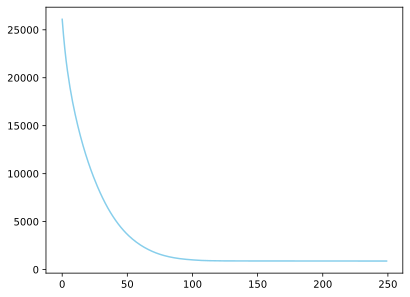

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.style.use("seaborn")

n_iter = 250
learning_rate = 0.001

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [20]:
learning = one_hot_encode(word_to_id["уединение"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

любят
Кошачьи
осторожны
ведут
ловкость
мясе
обычно
шипение
являются
послушание
мячом
кошки
имеют
ночной
Таким
точить
уникальными
количество
типичные
охотиться
домашние
особенностями
круп
сами
такую
это
человеком
кошками
зрения
таким
когти
независимы
эмоции
основном
открытость
свои
скрытность
С
отличаются
дружелюбие
Собаки
палкой
игры
активны
самостоятельны
шерстью
отличается
всеядны
Питание
днём
умеют
большего
Мяукание
друга
птицы
требуют
своей
питания
каждое
точки
существенно
которые
расчесывания
друг
разные
уединение
животные
необходимо
общего
также
образом
В
мурлыканье
легко
преимущественно
редко
стороны
овощей
источнике
рычать
напротив
лаять
внимания
регулярного
игривостью
прогулки
деревьям
добычу
стремлением
нуждаются
ухаживают
издаваемые
Кошки
Они
хищниками
грация
преданностью
прогулок
кошек
купании
жизни
дрессировке
поведения
поведении
мелкую
мяса
образ
получать
близкие
преобладает
достаточное
обожают
лазать
общению
пищи
собаки
выть
мыши
собак
своими
выражая
заметна
поддаются
ух

In [21]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print(f"'{word}' нет в корпесе текста")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["embeddings"]

In [22]:
get_embedding(model, "всеядны")

array([ 4.01939977e-01,  8.90495093e-01, -1.66338213e+00,  1.53249685e+00,
        5.76867120e-01,  5.71119144e-01, -8.59197834e-01,  5.72113071e-01,
        8.01245278e-01, -1.76194186e-01,  1.83657102e+00, -5.52849914e-02,
        1.33856998e+00,  1.87429421e-01,  7.06097362e-01, -1.66794102e+00,
        2.44486119e-01, -8.36011408e-01, -8.37152588e-01,  1.74840127e+00,
       -3.49397462e-01, -7.32538512e-01, -3.98217811e-01, -1.15357653e+00,
        1.61867169e+00, -6.51246339e-01,  3.74846739e-01,  1.37802191e+00,
       -5.74765816e-01,  4.45339161e-01, -1.06950564e+00,  2.43233220e+00,
        9.04485997e-01, -8.69310649e-02, -1.03644665e+00,  2.61177150e-02,
       -1.93313645e-01,  1.95545644e+00, -8.94497336e-01,  1.99951478e-01,
       -1.14844720e-01, -7.53358710e-02,  1.96329706e-01, -4.62033334e-01,
        9.25934403e-01,  4.66895027e-01,  4.76281099e-01, -2.93417727e+00,
        4.06975659e-01, -1.70719216e+00,  7.70101993e-01,  1.66725852e+00,
       -1.05147093e+00, -

In [23]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color="blue", width=600, height=400, show=True, **kwargs):
    """Функция для визуализации векторов"""
    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ "x": x, "y": y, "color": color, **kwargs })
    fig = pl.figure(active_scroll="wheel_zoom", width=width, height=height)
    fig.scatter("x", "y", size=radius, color="color", alpha=alpha, source=data_source)
    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig

Loading BokehJS ...

In [24]:
import numpy as np
import umap

unique_tokens = list(word_to_id.keys())
# Получаем эмбеддинги для каждого токена
embeddings = np.array([get_embedding(model, token) for token in unique_tokens])

# Уменьшаем размерность эмбеддингов до 2-х измерений с помощью UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_reducer.fit_transform(embeddings)

draw_vectors(embedding_2d[:, 0], embedding_2d[:, 1], tokens=tokens)

/Users/pakorolev/miniconda3/envs/nlp_course/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/pakorolev/miniconda3/envs/nlp_course/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


figure(id='p1004', ...)